In [89]:
#Cargando librerías 

from IPython.display import clear_output
import importlib

from PIL import Image
import matplotlib.pyplot as plt
import scipy as sp
#from scipy import ndimage as ndi
import numpy as np
import pandas as pd
import os
import sys  

from skimage.draw import line

root = os.getcwd() + "/.."


print("Root of the project:", root)

Root of the project: /Users/rodrigo/SourcesCodes/GitHub/light pollution sensor locations/optimization_sensor_locations_with_constraints/notebooks/..


In [91]:

sys.path.insert(0, root)


import src.positioning_sensors as ps
importlib.reload(ps)

import src.regionGrowing as rg
importlib.reload(rg)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

In [92]:
#We read the configuration of the experiment file
#we create the directory of the experiments


```
linz_experiment_with_initial_positions_no
├── linz_with_init_net_exp_2.txt
├── results
└── semivariances
```

In [93]:

fn = "linz_with_init_net_exp_2.txt"
me.createProject(fn)

Read File: ../experiments/linz_with_init_net_exp_2.txt
Creating Directory in: ../experiments/linz_experiment_with_initial_positions_no2/
Creating Directory ../experiments/linz_experiment_with_initial_positions_no2/results/
Creating Directory: ../experiments/linz_experiment_with_initial_positions_no2/semivariances/
Copy linz_with_init_net_exp_2.txt -> ../experiments/linz_experiment_with_initial_positions_no2/linz_with_init_net_exp_2.txt


In [94]:
setup = me.readConfigFile(fn)

In [95]:
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


locations/linz/world_atlas_linzn
locations/linz/linz_prioridades


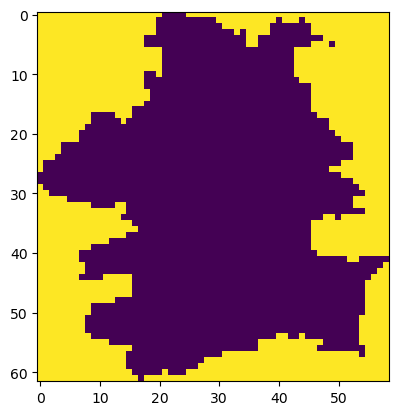

In [96]:
#cargamos imagenes en luminance e importance

print(setup["folder_input"] + setup["input_ntli"])
print(setup["folder_input"] + setup["input_evm"])

ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
niveles = cfg.data + setup["folder_input"] + setup["input_evm"]

img = niveles
im1 = np.array(Image.open(img))

plt.imshow(im1)

In [97]:
net = setup["init_fixed_net"]

In [98]:
net

[[34, 34], [34, 31], [35, 29], [36, 39], [39, 22]]

In [99]:
#NTLI: luminance
NTLI = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles, invert = True)

th = int(setup["desaturation_th"])

In [100]:
setup["input_evm"]

'linz_prioridades'

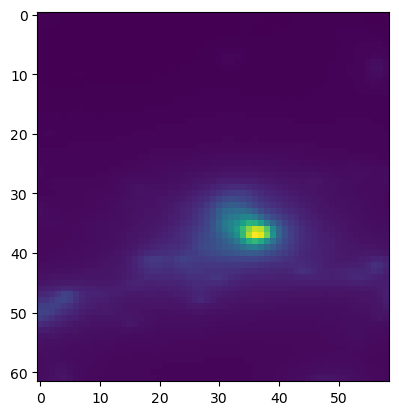

In [102]:
plt.imshow(NTLI)

In [103]:
np.max(NTLI)

5.0428257

In [227]:
EAM = (EAM>0)*1

In [228]:
np.shape(EAM)[0]*np.shape(EAM)[1]

3658

In [229]:
EAM[EAM==255]=1.0

EAMC = np.copy(EAM)

In [230]:
for n in net:
    EAMC[tuple(n)]=0

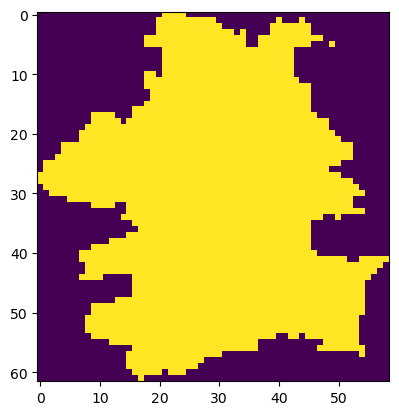

In [234]:
plt.imshow(EAM)



In [236]:
th

63

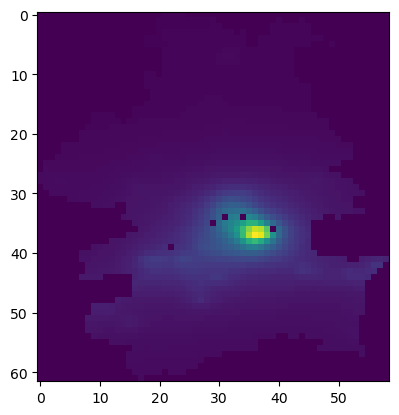

In [235]:
DNTLI, distance = ps.desaturate(NTLI, th = th)

plt.imshow(DNTLI*EAMC)

In [132]:
#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.gaussian_filter(NTLI, 
                                    sigma, 
                                    mode = setup['gaussian_mode']
                                   )


In [150]:
fxn = setup["init_fixed_net"]

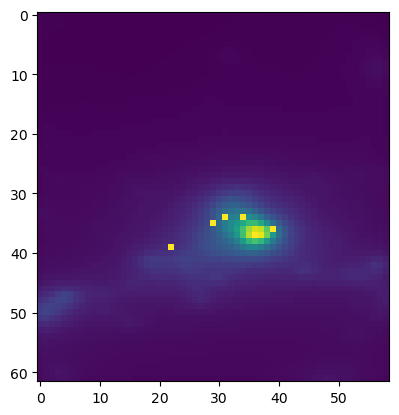

In [160]:
FDNTLI_LINZ = np.copy(FDNTLI)

for i in range(len(fxn)):
    
    si = tuple(fxn[i])
    FDNTLI_LINZ[si] = np.max(FDNTLI_LINZ)

plt.imshow(FDNTLI_LINZ)


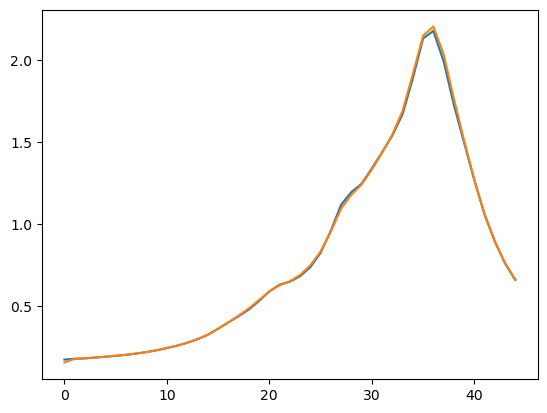

In [161]:
i = 1
r = si[i]
#plt.plot(NTLI[si[0],si[1]-r:si[1]+r+1])
plt.plot(NTLI[si[0], si[1] - r:si[1] + r + 1])
plt.plot(FDNTLI[si[0], si[1] - r:si[1] + r + 1])
#plt.vlines(si[1],0,np.max(nonsat2[si[0],:]))


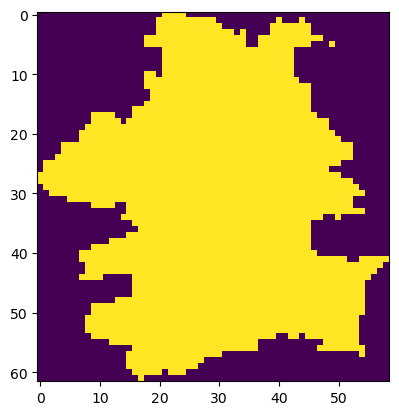

In [162]:
plt.imshow(EAM)

In [163]:
EAM = EAM.astype(float)

In [238]:
np.sum(EAM)

2147

In [166]:
setup["neglect_values"]

0.2

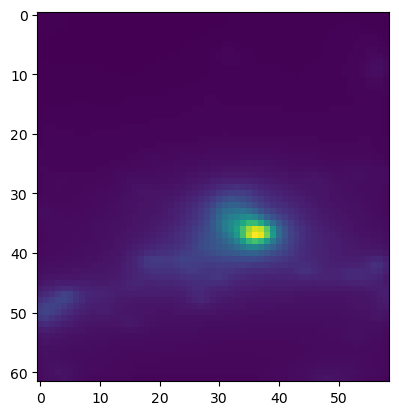

In [206]:
coords = ps.get_coords(EAM > 0)

In [207]:
#fill the required params
#si = (28,19)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()



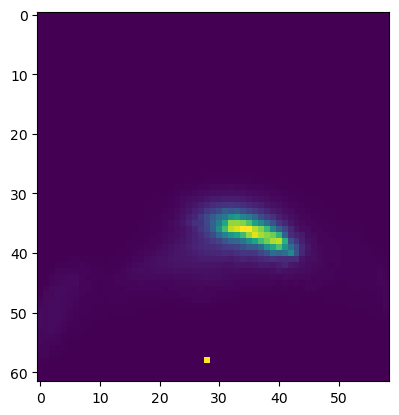

In [208]:
sv = rG.makeSemivarianceMap(si)
svc = np.copy(sv)
svc[si] = np.max(sv)
plt.imshow(svc)

In [209]:
svf = sv.flatten()

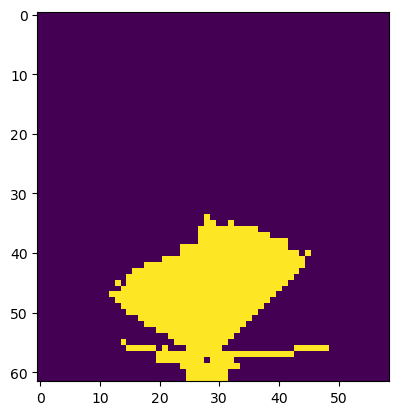

In [210]:
masksv = ps.constructMask(si, sv, flat_means_decrease)
masksv[si] = 0
plt.imshow(masksv)

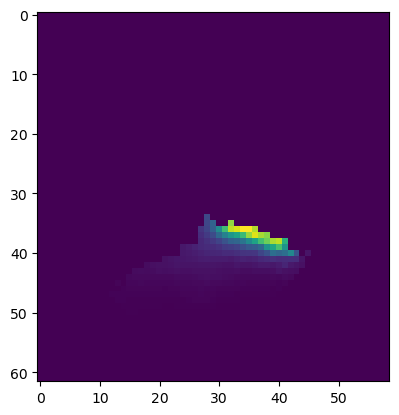

In [211]:
plt.imshow(masksv*svc)


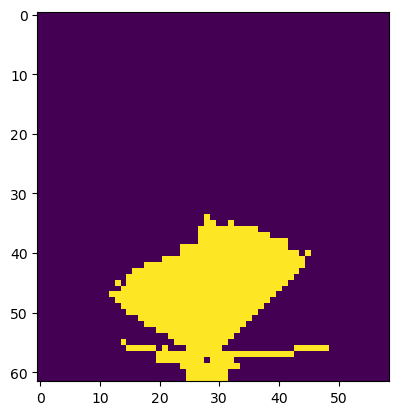

In [212]:
plt.imshow(masksv)

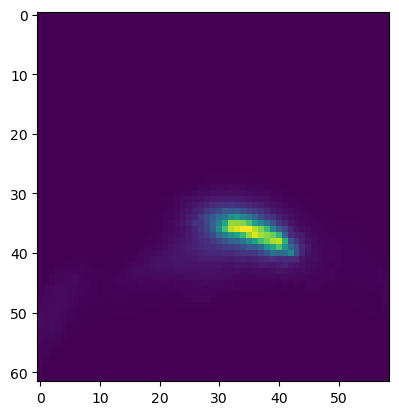

In [213]:
plt.imshow(sv)

In [214]:
len(coords)

2147

In [215]:
sv.shape[0]*sv.shape[1]

3658

In [237]:
len(coords)

2147

In [217]:
print("coords:", si)
    
clear_output(wait = True)
s = "{percen: 1.2f}%"
print(s.format(percen = 100*(i + 1)/n))
    
si = tuple(si)

#generate a semivariance sv map
sv = rG.makeSemivarianceMap(si)
    
#flattne sv to store it in a dataframe
semivar_brat = sv.flatten()
    
#construct a mask of sv and then flatten it
semivar_brat_mask = ps.constructMask(si, sv, flat_means_decrease).flatten()

 170.38%


In [218]:
semivar_brat_mask

array([0., 0., 0., ..., 0., 0., 0.])

In [240]:
np.sum(EAM)
len(coords)

2147

# parte mas importante del notebook

In [241]:
for i, si in enumerate(coords):
    print("coords:", si)
    
    clear_output(wait = True)
    s = "{percen: 1.2f}%"
    print(s.format(percen = 100*(i + 1)/n))
    
    si = tuple(si)

    #generate a semivariance sv map
    sv = rG.makeSemivarianceMap(si)
    
    #flattne sv to store it in a dataframe
    allsemivariances[i] = sv.flatten()
    
    #construct a mask of sv and then flatten it
    allmask[i] = ps.constructMask(si, sv, flat_means_decrease).flatten()

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [191]:
svc = np.copy(sv)

In [192]:
svc[tuple(si)] = np.max(svc)

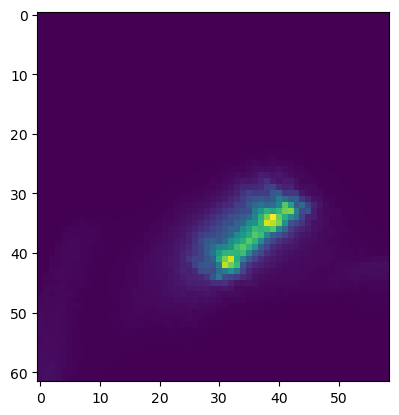

In [193]:
plt.imshow(sv)

In [194]:
maskf = ps.constructMask(si, sv, flat_means_decrease).flatten()

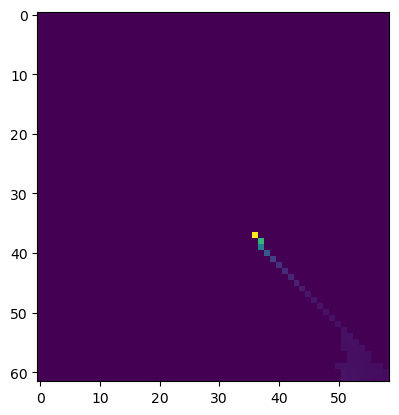

In [195]:
plt.imshow(maskf.reshape(sv.shape)*FDNTLI_LINZ)

In [196]:
P = ps.perimeter(sv)

In [197]:
FDNTLI.shape

(62, 59)

In [198]:
sv.shape

(62, 59)

In [199]:
for pix in P:
    sv[pix]

In [200]:
pix

(61, 58)

In [201]:
np.shape(sv)

(62, 59)

In [202]:
si = (58, 28)

In [203]:
#path to save collection of semivariances

prefix_path = (cfg.experiment + setup["experiment_id"] 
          + setup["folder_semivariances"] 
          + setup["output_semivariances"])


filesv = ( prefix_path + ".csv")

print("Semivariances saved at: ", filesv)

#filesvmask = (cfg.experiment + setup["experiment_id"] 
#              + setup["folder_semivariances"] 
#              + setup["output_semivariances"] 
#              + "mask.csv")


#path to save collection of masks
#each semivariance map is associated with a mask.
#mask defines the region of influence

filesvmask = (prefix_path + "mask.csv")

print("Semivariances mask saved to: ", filesvmask)

Semivariances saved at:  ../experiments/linz_experiment_with_initial_positions_no2/semivariances/semivariance050512022.csv
Semivariances mask saved to:  ../experiments/linz_experiment_with_initial_positions_no2/semivariances/semivariance050512022mask.csv


In [204]:


df_semivariance = pd.DataFrame(allsemivariances)
df_semivariance.insert(0, "coordsy", coords[:,0]) 
df_semivariance.insert(1, "coordsx", coords[:,1])
df_semivariance.to_csv(filesv)

df_semivariance_mask = pd.DataFrame(allmask)
df_semivariance_mask.insert(0, "coordsy", coords[:,0]) 
df_semivariance_mask.insert(1, "coordsx", coords[:,1])
df_semivariance_mask.to_csv(filesvmask)